# Object Detection Demo

Be sure to install the optional requirements:

Minimum install:

```shell
$ pip install -e .[hydra_zen,huggingface]
```

Full install:

```shell
$ pip install -e .[hydra_zen,smqtk,huggingface]
```

## Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from io import BytesIO
from typing import Dict, List, Sequence

import numpy as np
import requests
from PIL import Image

from jatic_toolbox.interop import ObjectDetectionOutput
from jatic_toolbox.protocols import (
    HasObjectDetections,
    ImageType,
    ObjectDetector,
)


## Object Detection Pipeline

Here we define a simple detection pipeline using `jatic_toolbox.protocols`. 

In [2]:
def eval_image_detector(
    detector: ObjectDetector, data: Sequence[ImageType], threshold: float = 0.4
) -> ObjectDetectionOutput:
    """
    Evalulator for Object Detection Models.

    Parameters
    ----------
    detector : Model
        A `jatic_toolbox.protocols.Model` object.

    img_iter : Sequence[ImageType]
        A sequence of images (PIL.Image, NDArray, or torch.Tensor)

    threshold : float = 0.4
        Value to threshold detections.

    Returns
    -------
    ObjectDetectionOutput
        Collections of bounding boxes and scores.
    """
    output = detector(data)
    assert isinstance(output, HasObjectDetections)
    boxes = np.asarray(output.boxes)
    scores = output.scores

    boxes_threshold: List[np.ndarray] = []
    scores_threshold: List[List[Dict[str, float]]] = []
    for boxes_per_image, scores_per_image in zip(boxes, scores):

        _image_boxes = []
        _image_scores: List[Dict[str, float]] = []
        for boxes, score_dict in zip(boxes_per_image, scores_per_image):
            cls_idx = max(score_dict, key=score_dict.get)
            conf = score_dict[cls_idx]

            if conf >= threshold:
                _image_boxes.append(boxes)
                _image_scores.append({cls_idx: conf})
        
        boxes_threshold.append(np.asarray(_image_boxes))
        scores_threshold.append(_image_scores)

    return ObjectDetectionOutput(boxes=boxes_threshold, scores=scores_threshold)


## Example Image

(-0.5, 959.5, 539.5, -0.5)

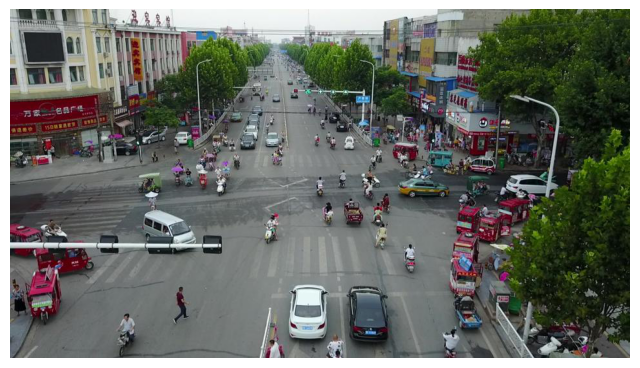

In [3]:
url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))
img = np.asarray(img_pil)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")


### Evaluate and Plot

In [4]:
def show_dets(ax, dets: ObjectDetectionOutput, image_index: int, add_prediction: bool=False):
    all_boxes = np.asarray(dets.boxes)
    all_scores = dets.scores
    assert len(all_boxes) == len(all_scores), "must have same batch size"
    bboxes = all_boxes[image_index]
    scores = all_scores[image_index]

    assert len(bboxes) == len(scores), "must have same number of detections and scores per image"

    for bbox, score_dict in zip(bboxes, scores):
        cls_idx = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_idx]

        x1, y1 = bbox[:2]
        x2, y2 = bbox[-2:]
        ax.add_patch(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
        )

        if add_prediction:
            ax.text(x1, y1, f"{cls_idx}: {conf:.1f}", fontsize=4)


In [5]:
try:
    from jatic_toolbox.interop.smqtk import CenterNetVisdrone

    model = CenterNetVisdrone()
    
    print(f"Loading URL: {url}")
    response = requests.get(url)
    img_pil = Image.open(BytesIO(response.content))
    img = np.asarray(img_pil)
    dets = eval_image_detector(model, [img], threshold=0.4)

    # run validation check, throws an error if
    # boxes is not a list of NumPy arrays
    # with a detection index and box dimension.
    assert len(dets.boxes) == 1


    fig, axs = plt.subplots(figsize=(8, 8))
    axs.set_title(f"Model: SMQTK CenterNet")
    axs.imshow(img)
    axs.axis("off")
    show_dets(axs, dets, image_index=0, add_prediction=True)
except ImportError:
    ...

c:\Users\JU17693\Anaconda3\envs\jatic\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
c:\Users\JU17693\Anaconda3\envs\jatic\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Loading URL: https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download


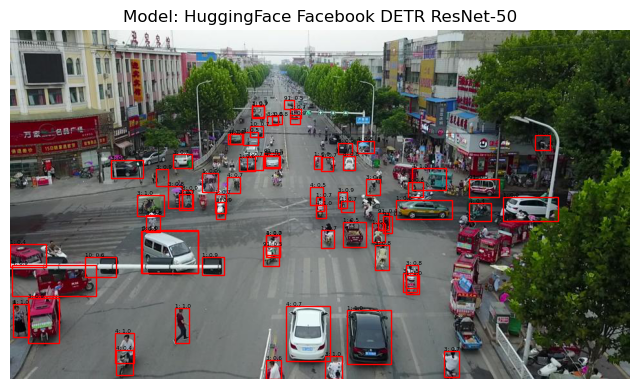

In [6]:
from jatic_toolbox.interop.huggingface import HuggingFaceObjectDetector

model = HuggingFaceObjectDetector("facebook/detr-resnet-50")
 
print(f"Loading URL: {url}")
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))
img = np.asarray(img_pil)
dets = eval_image_detector(model, [img], threshold=0.4)

# run validation check, throws an error if
# boxes is not a list of NumPy arrays
# with a detection index and box dimension.
assert len(dets.boxes) == 1


fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Model: HuggingFace Facebook DETR ResNet-50")
axs.imshow(img)
axs.axis("off")
show_dets(axs, dets, image_index=0, add_prediction=True)

## User Interface with IPyWidgets

In this section we will demonstrate using `hydra-zen` configs generated for HuggingFace and SMQTK object detector to build
a UI for selecting different models and visualizing detections using IPyWidgets.

In [7]:
from hydra_zen import instantiate

try:
    from jatic_toolbox._internals.interop.hydra_zen import create_smqtk_model_config

    # create the configs and add to the config store (this is an in-memory only storage)
    jatic_configs = create_smqtk_model_config()
    jatic_configs["model"]
except ImportError:
    ...


In [8]:
from jatic_toolbox.interop.hydra_zen import create_huggingface_model_config

from huggingface_hub import (
    HfApi,
    ModelFilter,
    ModelSearchArguments,
)

# using the HuggingFace API to search for available modles
# that meet a given query.
api = HfApi()
model_args = ModelSearchArguments()

filt = ModelFilter(
    task=model_args.pipeline_tag.ObjectDetection,
    author="facebook",
    model_name="detr",
    library=model_args.library.PyTorch,
    
)

# create configs and add to the config store
jatic_configs = create_huggingface_model_config(filter=filt)

c:\Users\JU17693\Anaconda3\envs\jatic\lib\site-packages\huggingface_hub\utils\_deprecation.py:233: FutureWarning: 'list_models' currently returns a list of objects but is planned to be a generator starting from version 0.14 in order to implement pagination. Please avoid to use `list_models(...).__len__` or explicitly convert the output to a list first with `list(iter(list_models)(...))`.
  warnings.warn(self._deprecation_msg.format(attr_name=attr_name), FutureWarning)


In [9]:
from ipywidgets import widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output


# extract the config names for all models in the config store
models = [k[1] for k in jatic_configs["model"].keys()]

# add the models to a drop down menu
obj_det = widgets.Dropdown(
    options=models,
    value=models[0],
    description='Object Detectors:',
    layout=widgets.Layout(width="max-content")
)

button = widgets.Button(description="Launch!", layout=widgets.Layout(margin="30px"))
output = widgets.Output()

display(obj_det, button, output)

def on_button_clicked(b):
    with output:
        if len(obj_det.value) > 0:
            clear_output()

            print(f"Loading URL: {url}")
            response = requests.get(url)
            img_pil = Image.open(BytesIO(response.content))
            img = np.asarray(img_pil)

            print(f"Launching run on {obj_det.value}")

            model = instantiate(jatic_configs["model", obj_det.value])
            dets = eval_image_detector(model, [img], threshold=0.4)

            fig, axs = plt.subplots(figsize=(8, 8))
            axs.set_title(f"Model: {obj_det.value}")
            axs.imshow(img)
            axs.axis("off")
            show_dets(axs, dets, 0, add_prediction=True)
            show_inline_matplotlib_plots()
        else:
            print(f"Please select a model")

button.on_click(on_button_clicked)

Dropdown(description='Object Detectors:', layout=Layout(width='max-content'), options=('facebook__detr-resnet-…

Button(description='Launch!', layout=Layout(margin='30px'), style=ButtonStyle())

Output()